In [1]:
from influxdb import InfluxDBClient
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

In [2]:
# InfluxDB host address and user credentials
host = "192.168.178.63"
username = "influx_user_1"

# This ipython widget input for the password avoids storing the password into the notebook.
display(widgets.Label(f'Enter password for {username=}:'))
pw = widgets.Password(value="password")
display(pw)

Label(value="Enter password for username='influx_user_1':")

Password()

In [4]:
client = InfluxDBClient(host=host, port=8086, username=username, password=pw.value)
client.get_list_database()

[{'name': '_internal'},
 {'name': 'influx_db_1'},
 {'name': 'influx_db_2'},
 {'name': 'influx_db_3'},
 {'name': 'influx_db_4'}]

In [5]:
client.switch_database('influx_db_4')

In [17]:
records = list()
for point in ["unit=" + p["key"] for p in client.query("show series").get_points()]:
    # point example: unit=kWh,domain=sensor,entity_id=sma_battery_charge_total
    record = dict()
    for item in point.split(","):
        key, value = item.split("=")
        record[key] = value
    records.append(record)
entities = pd.DataFrame.from_records(records)

In [18]:
entities.sample(6)

,unit,domain,entity_id
50,A,sensor,sn_3015663157_battery_current_a
239,state,sensor,io_series_8_9_2e3c_number_of_sectors
32,%,sensor,silkes_huawei_battery_level
95,W,sensor,power_imported
178,m³,sensor,watermeter_value
44,A,sensor,sma_current_total


In [19]:
entities.domain.value_counts()

domain
sensor           228
binary_sensor     49
Name: count, dtype: int64

In [21]:
entities.unit.value_counts().sort_index()

unit
%                     43
A                     19
B                      3
GB                     1
GiB                    2
Hz                     2
Mbit/s                 2
MiB                    2
UV\ index              1
V                      6
W                     46
Wh                     2
dBm                    3
h                      1
hPa                    2
kW                     1
kWh                   17
kWh/100km              1
km                     4
km/h                   2
l                      1
lx                     2
m                      1
min                    3
mm                     3
mm/h                   2
ms                     1
m³                     6
m³/h                   3
pending\ update(s)     1
s                      4
state                 64
steps                  1
°                      3
°C                    20
µS/cm                  2
Name: count, dtype: int64

In [32]:
entities[entities.unit == "m³"]

,unit,domain,entity_id
173,m³,sensor,gasmeter2_rate_per_digitalization_round
174,m³,sensor,gasmeter2_value
175,m³,sensor,gasmeter_rate_per_digitalization_round
176,m³,sensor,gasmeter_value
177,m³,sensor,watermeter_rate_per_digitalization_round
178,m³,sensor,watermeter_value


In [52]:
unit = "m³"
entity_id = "watermeter_value"
selection = "mean_value"
qstr = f'SELECT {selection} FROM "{unit}" WHERE {entity_id=}'
df = pd.DataFrame.from_records(client.query(qstr).get_points())
df.tail(2)

,time,mean_value
1921,2024-03-24T11:00:00Z,606.665100
1922,2024-03-24T12:00:00Z,606.692433


In [53]:
df["datetime"] = pd.to_datetime(df.time)
df["date"] = [t.date() for t in df.datetime]
df["time"] = [t.time() for t in df.datetime]
df["diff"] = df["mean_value"].diff()
df.tail(2)

,time,mean_value,datetime,date,diff
1921,11:00:00,606.665100,2024-03-24 11:00:00+00:00,2024-03-24,0.063600
1922,12:00:00,606.692433,2024-03-24 12:00:00+00:00,2024-03-24,0.027333


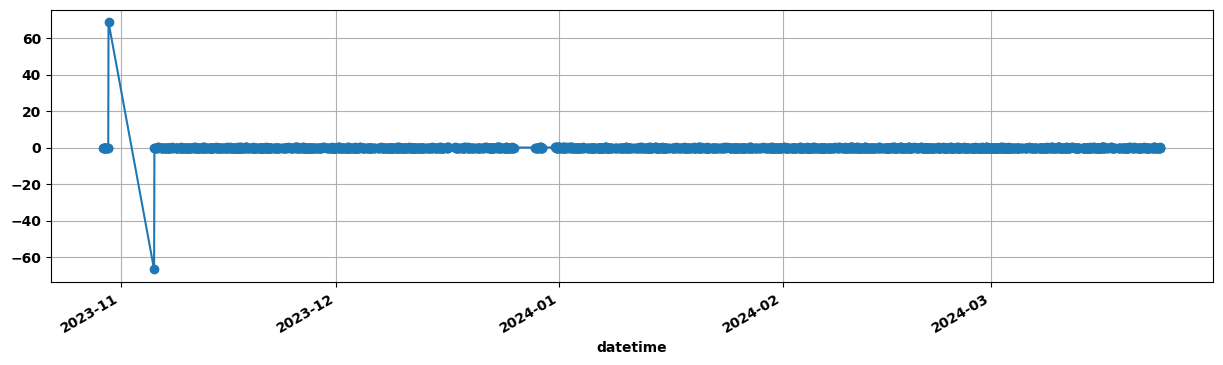

In [54]:
%matplotlib inline
df.set_index("datetime")["diff"].plot(figsize=(15,4), grid=True, marker="o");

In [55]:
pt = df.pivot_table(values="diff", columns="date", index="time")
pt.tail(2)

date,2023-10-29,2023-10-30,2023-11-05,2023-11-06,2023-11-07,2023-11-08,2023-11-09,2023-11-10,2023-11-11,2023-11-12,...,2024-03-15,2024-03-16,2024-03-17,2024-03-18,2024-03-19,2024-03-20,2024-03-21,2024-03-22,2024-03-23,2024-03-24
time,,,,,,,,,,,,,,,,,,,,,
22:00:00,NaN,NaN,NaN,0.0092,0.0037,0.0075,0.0022,NaN,NaN,0.0012,...,0.000317,0.0031,0.00505,NaN,0.0,0.0018,NaN,0.00345,0.01295,NaN
23:00:00,0.0072,NaN,0.0043,NaN,NaN,NaN,NaN,NaN,0.0039,NaN,...,-0.000017,NaN,0.00320,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [65]:
mpl.cm.RdYlGn

<module 'matplotlib.cm' from 'c:\\Users\\holge\\anaconda3\\envs\\influx\\Lib\\site-packages\\matplotlib\\cm.py'>

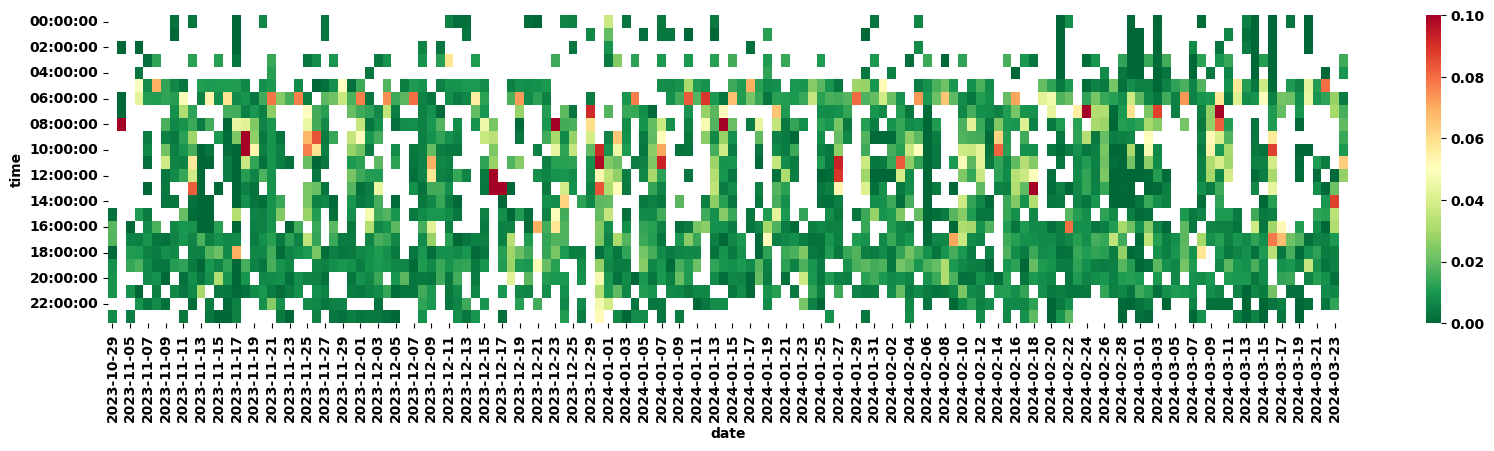

In [69]:
plt.figure(figsize=(20,4))
sns.heatmap(pt, cmap=mpl.cm.RdYlGn_r, vmin=0, vmax=.1);

In [31]:
pt.max().max(), pt.min().min()

(1.2284, -0.4442345)

In [ ]:
pt.index = [t.hour for t in pt.index]
pt.columns = [i for i in range(len(pt.columns))]
ny, nx = pt.values.shape
y = np.vstack(nx*[pt.index.values]).T
x = np.vstack(ny*[pt.columns.values])

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x,y, pt.values, cmap=mpl.cm.OrRd_r,
                       linewidth=0, antialiased=False)
plt.show;